# 逻辑回归

在训练的初始阶段，我们将要构建一个逻辑回归模型来预测，某个学生是否被大学录取。设想你是大学相关部分的管理者，想通过申请学生两次测试的评分，来决定他们是否被录取。现在你拥有之前申请学生的可以用于训练逻辑回归的训练样本集。对于每一个训练样本，你有他们两次测试的评分和最后是被录取的结果。为了完成这个预测任务，我们准备构建一个可以基于两次测试评分来评估录取可能性的分类模型。

## 检查数据

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [177]:
path = "ex2data1.txt"
data = pd.read_csv(path,header=None,names=["exam1","exam2","admitted"])
data.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


创建散点图

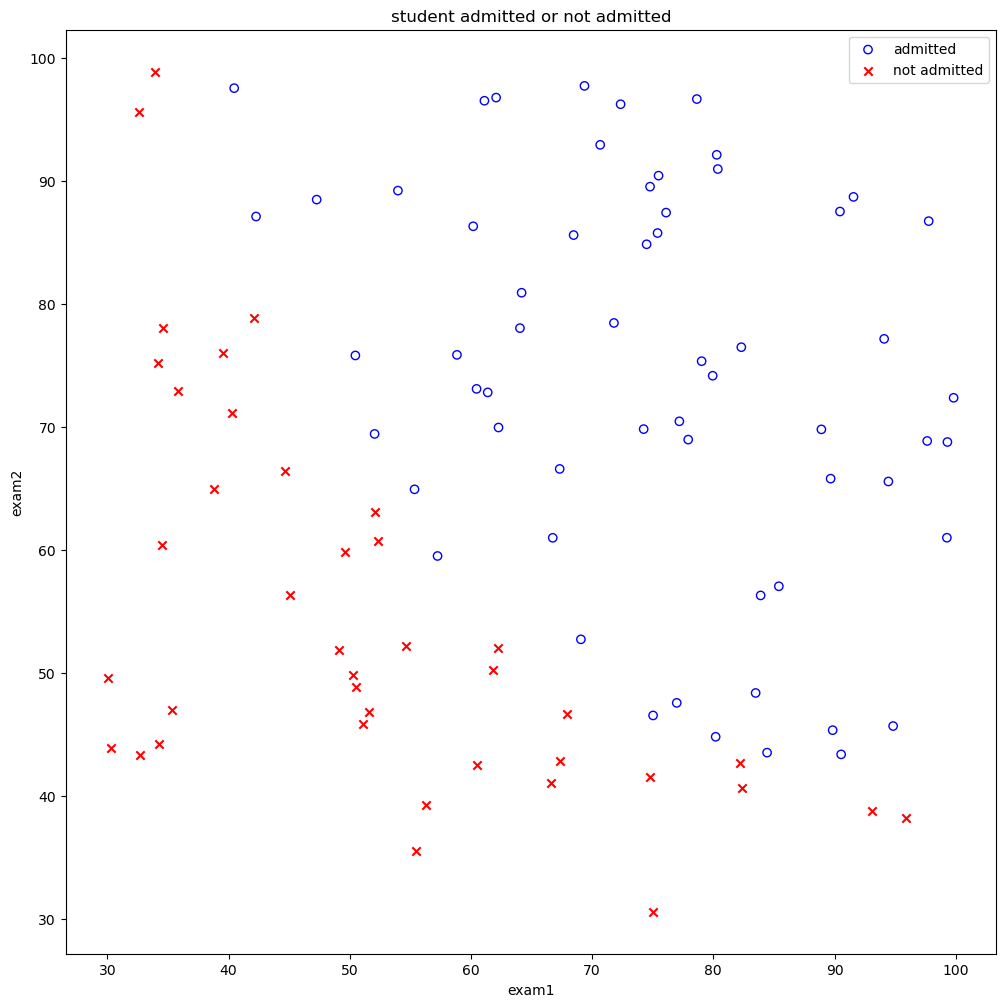

In [178]:
positive = data[data["admitted"]==1]
negative = data[data["admitted"]==0]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.scatter(positive["exam1"],positive["exam2"],marker="o",edgecolors="blue",facecolors="none",label="admitted")
ax.scatter(negative["exam1"],negative["exam2"],marker="x",color="r",label="not admitted")
ax.legend(loc="best")
ax.set_xlabel("exam1")
ax.set_ylabel("exam2")
ax.set_title("student admitted or not admitted")
plt.show()

在两类之间有一个清晰的决策边界，接下来实现逻辑回归，从而训练一个模型预测结果

## sigmoid函数

g(z)为一个常用的逻辑函数（logistic function），是s形函数（sigmoid function）  
公式为：$g\left(z\right)=\frac{1}{1+{{e}^{-z}}}$,其中$z=f(x)=\theta^T X$  
合并为：
$${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$$

In [179]:
def sigmoid(z):
    return 1 / (1 + (np.exp(-z)))

检验sigmoid函数

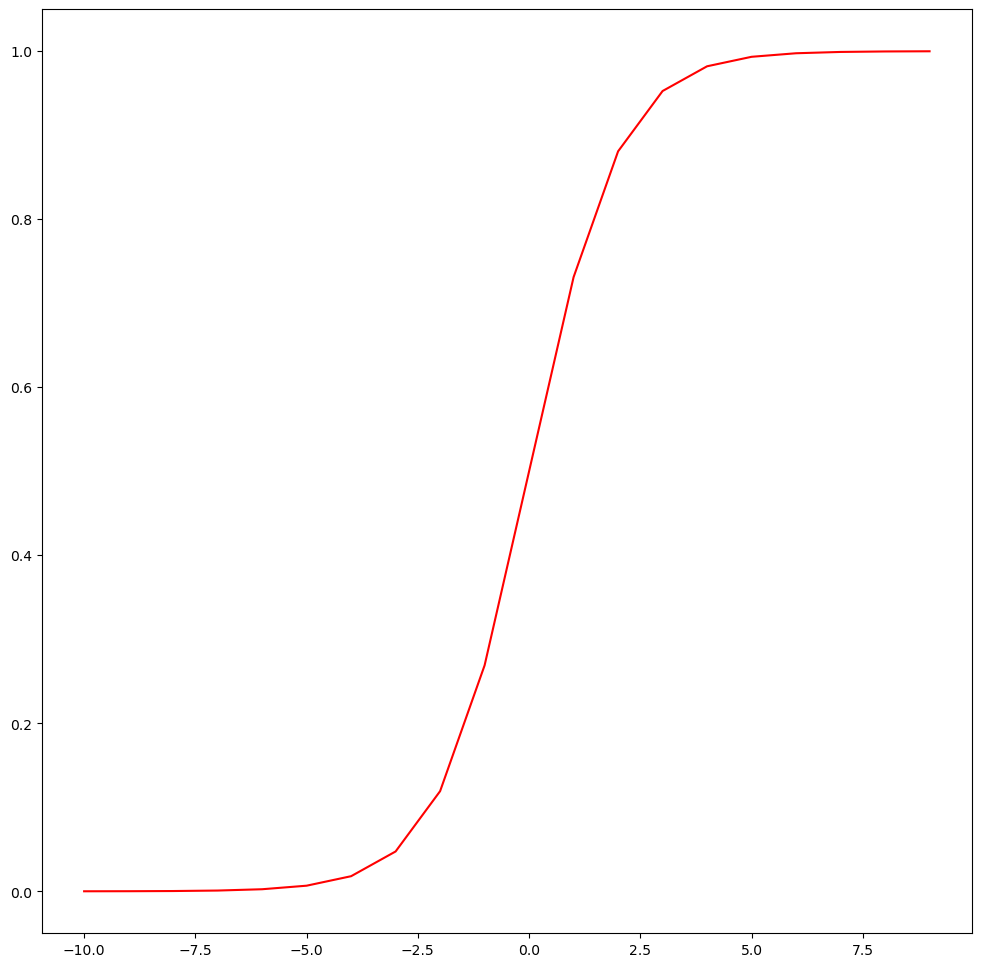

In [180]:
nums = np.arange(-10,10,1)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.plot(nums,sigmoid(nums),color="r")
plt.show()

## 代价函数

为了评估模型的结果，因此编写代价函数  
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$$

In [181]:
def cost(theta,X,y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y,np.log(sigmoid(X*theta.T)))
    second = np.multiply((1-y),np.log(1-sigmoid(X*theta.T)))
    return np.sum(first - second) / len(X)

验证cost函数

In [182]:
data.insert(0,"ones",1)
data.head()

,ones,exam1,exam2,admitted
0,1,34.623660,78.024693,0
1,1,30.286711,43.894998,0
2,1,35.847409,72.902198,0
3,1,60.182599,86.308552,1
4,1,79.032736,75.344376,1


In [183]:
cols = data.shape[1]
X = data.iloc[:,:cols-1]
y = data.iloc[:,cols-1:cols]

In [184]:
print(X)
print(y)

    ones      exam1      exam2
0      1  34.623660  78.024693
1      1  30.286711  43.894998
2      1  35.847409  72.902198
3      1  60.182599  86.308552
4      1  79.032736  75.344376
..   ...        ...        ...
95     1  83.489163  48.380286
96     1  42.261701  87.103851
97     1  99.315009  68.775409
98     1  55.340018  64.931938
99     1  74.775893  89.529813

[100 rows x 3 columns]
    admitted
0          0
1          0
2          0
3          1
4          1
..       ...
95         1
96         1
97         1
98         1
99         1

[100 rows x 1 columns]


In [185]:
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(X.shape[1])

In [186]:
X.shape,theta.shape,y.shape

((100, 3), (3,), (100, 1))

In [187]:
cost(theta,X,y)

0.6931471805599453

## gradient descent

* 这是批量梯度下降（batch gradient descent)
* 转化为向量化计算：$\frac{1}{m}X^{(i)}(Sigmoid(X\theta)-y)$

$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [188]:
def gradient(theta,X,y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    err = sigmoid(X*theta.T) - y

    for i in range(parameters):
        term = np.multiply(err,X[:,i])
        grad[i] = np.sum(term) / len(X)
    
    return grad

注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算一个梯度步长。

In [189]:
gradient(theta,X,y)

array([ -0.1       , -12.00921659, -11.26284221])

## 进行梯度下降算法

$\theta_j=\theta_j-\alpha\frac{1}{m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$

In [190]:
import math
def compute_gradient(theta,X,y,iters,alpha):
    J_history = []

    for i in range(iters):
        grad = gradient(theta,X,y)
        theta = theta - np.multiply(alpha,grad)
        J_history.append(cost(theta,X,y))

        if i % math.ceil(iters / 100) == 0:
            print(f"iters:{i:4d},theta:{theta},J:{J_history[-1]}")
    result = theta
    return result,J_history

In [191]:
theta = np.zeros_like(X[0])
iters = 600000
alpha = 0.001
theta,J = compute_gradient(theta,X,y,iters,alpha)

iters:   0,theta:[0.0001     0.01200922 0.01126284],J:0.6982906893667754
iters:6000,theta:[-0.40831836  0.01326701  0.00362916],J:0.6020195186760547
iters:12000,theta:[-0.79606337  0.01598422  0.00665499],J:0.5769536144879259
iters:18000,theta:[-1.1643991   0.01858299  0.00953553],J:0.5543344168653271
iters:24000,theta:[-1.51452054  0.02106963  0.01227811],J:0.5338970707443537
iters:30000,theta:[-1.84761893  0.02345052  0.01489053],J:0.5153988893660557
iters:36000,theta:[-2.16485475  0.02573194  0.01738074],J:0.4986207103753809
iters:42000,theta:[-2.467339    0.02791996  0.01975663],J:0.4833667713556281
iters:48000,theta:[-2.75612129  0.03002039  0.02202587],J:0.46946360923757036
iters:54000,theta:[-3.03218345  0.03203873  0.0241958 ],J:0.4567583878473045
iters:60000,theta:[-3.29643712  0.03398016  0.02627331],J:0.4451169511500123
iters:66000,theta:[-3.54972417  0.03584951  0.02826488],J:0.43442180557726034
iters:72000,theta:[-3.79281905  0.03765128  0.03017651],J:0.4245701603262569
it

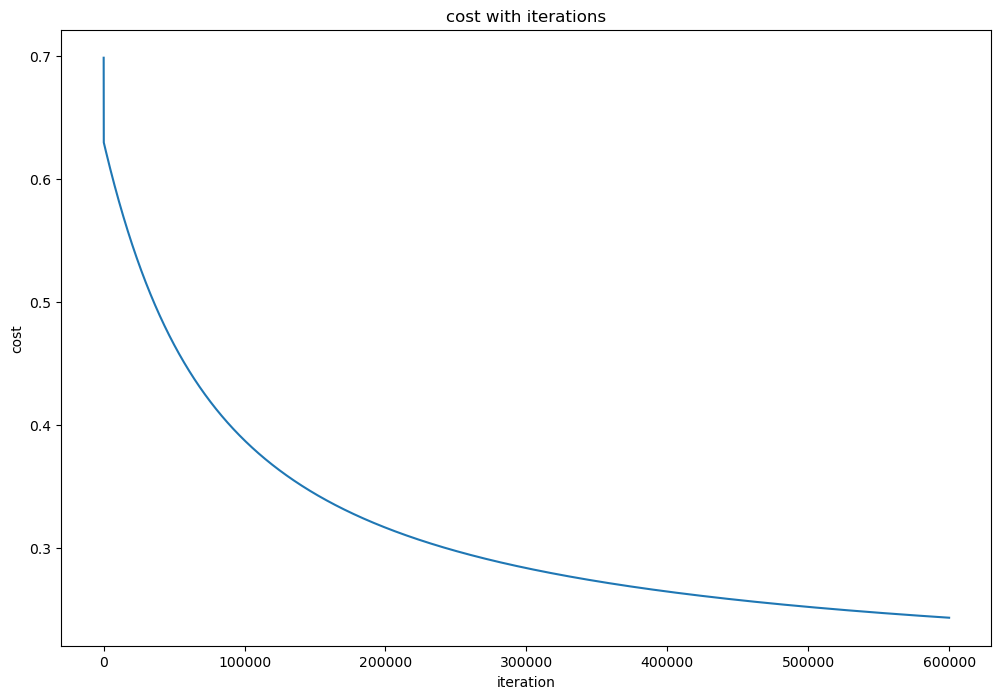

In [192]:
x = np.arange(0,iters,1)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
ax.plot(x,J)
ax.set_xlabel("iteration")
ax.set_ylabel("cost")
ax.set_title("cost with iterations")
plt.show()

In [193]:
theta


array([-12.68403191,   0.10669959,   0.10066959])

In [194]:
theta0 = theta[0]
theta1 = theta[1]
theta2 = theta[2]
print(theta0,theta1,theta2)

# 生成决策边界线数据
x1_values = np.linspace(30, 100, 100)
x2_values = (theta0 + theta1 * x1_values) / (-theta2)
print(x2_values)

-12.6840319106426 0.10669959002534056 0.10066958681080714
[94.19969338 93.45026987 92.70084637 91.95142286 91.20199936 90.45257585
 89.70315235 88.95372884 88.20430534 87.45488183 86.70545833 85.95603482
 85.20661132 84.45718782 83.70776431 82.95834081 82.2089173  81.4594938
 80.71007029 79.96064679 79.21122328 78.46179978 77.71237627 76.96295277
 76.21352926 75.46410576 74.71468225 73.96525875 73.21583524 72.46641174
 71.71698824 70.96756473 70.21814123 69.46871772 68.71929422 67.96987071
 67.22044721 66.4710237  65.7216002  64.97217669 64.22275319 63.47332968
 62.72390618 61.97448267 61.22505917 60.47563567 59.72621216 58.97678866
 58.22736515 57.47794165 56.72851814 55.97909464 55.22967113 54.48024763
 53.73082412 52.98140062 52.23197711 51.48255361 50.7331301  49.9837066
 49.23428309 48.48485959 47.73543609 46.98601258 46.23658908 45.48716557
 44.73774207 43.98831856 43.23889506 42.48947155 41.74004805 40.99062454
 40.24120104 39.49177753 38.74235403 37.99293052 37.24350702 36.4940

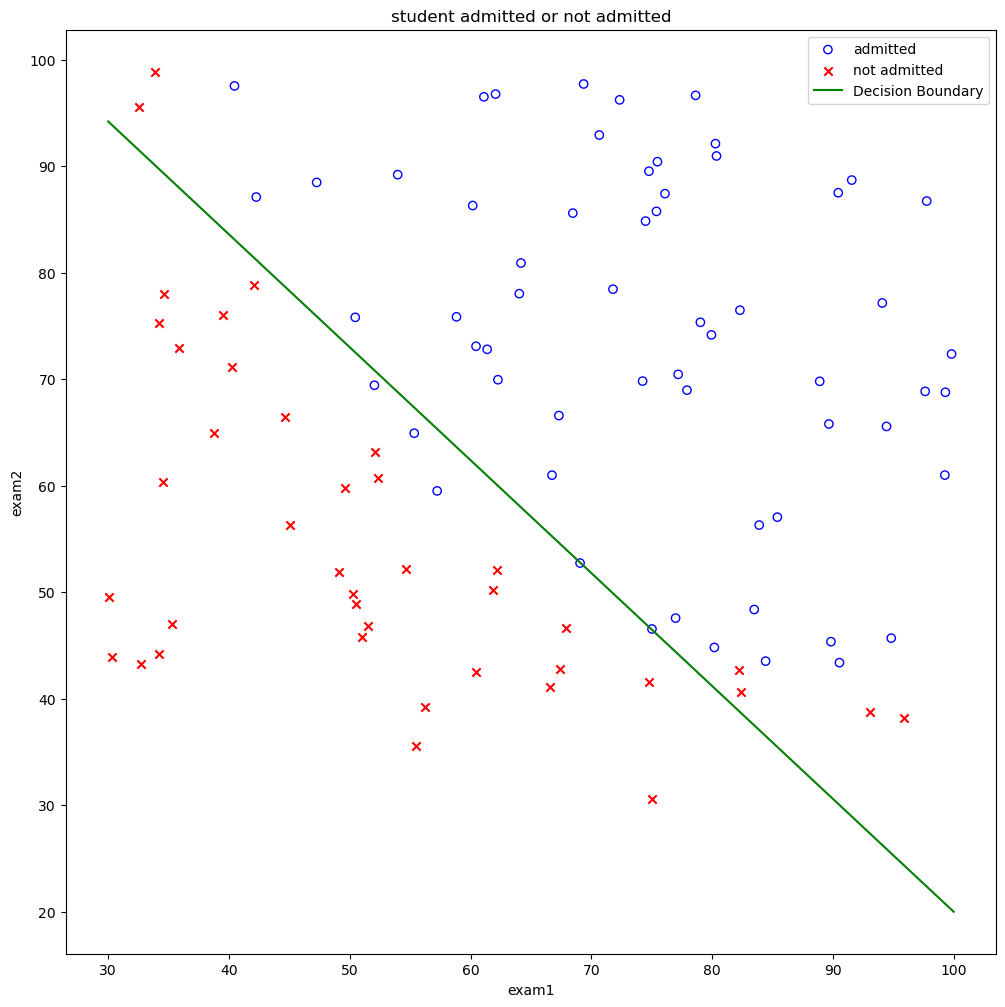

In [195]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.scatter(positive["exam1"],positive["exam2"],marker="o",edgecolors="blue",facecolors="none",label="admitted")
ax.scatter(negative["exam1"],negative["exam2"],marker="x",color="r",label="not admitted")
ax.plot(x1_values, x2_values, color="green", label="Decision Boundary")
ax.legend(loc="best")
ax.set_xlabel("exam1")
ax.set_ylabel("exam2")
ax.set_title("student admitted or not admitted")
plt.show()

## 用SciPy的“optimize”命名空间来做同样的事情。

现在可以用SciPy's truncated newton（TNC）实现寻找最优参数。

In [196]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost,x0=theta,fprime=gradient,args=(X,y))
result

(array([-25.16123246,   0.20623088,   0.20147081]), 27, 1)

In [197]:
cost(result[0],X,y)

0.20349770159097802

In [198]:
result0 = result[0][0]
result1 = result[0][1]
result2 = result[0][2]
print(result0,result1,result2)

# 生成决策边界线数据
x1 = np.linspace(30, 100, 100)
x2 = (result0 + result1 * x1_values) / (-result2)
print(x2)

-25.161232463425755 0.20623088226422687 0.2014708060489589
[94.17893524 93.45515883 92.73138243 92.00760602 91.28382962 90.56005321
 89.83627681 89.1125004  88.388724   87.66494759 86.94117119 86.21739478
 85.49361838 84.76984197 84.04606557 83.32228916 82.59851276 81.87473635
 81.15095995 80.42718354 79.70340714 78.97963073 78.25585433 77.53207792
 76.80830152 76.08452511 75.36074871 74.6369723  73.9131959  73.18941949
 72.46564309 71.74186668 71.01809027 70.29431387 69.57053746 68.84676106
 68.12298465 67.39920825 66.67543184 65.95165544 65.22787903 64.50410263
 63.78032622 63.05654982 62.33277341 61.60899701 60.8852206  60.1614442
 59.43766779 58.71389139 57.99011498 57.26633858 56.54256217 55.81878577
 55.09500936 54.37123296 53.64745655 52.92368015 52.19990374 51.47612734
 50.75235093 50.02857453 49.30479812 48.58102172 47.85724531 47.13346891
 46.4096925  45.6859161  44.96213969 44.23836328 43.51458688 42.79081047
 42.06703407 41.34325766 40.61948126 39.89570485 39.17192845 38.44

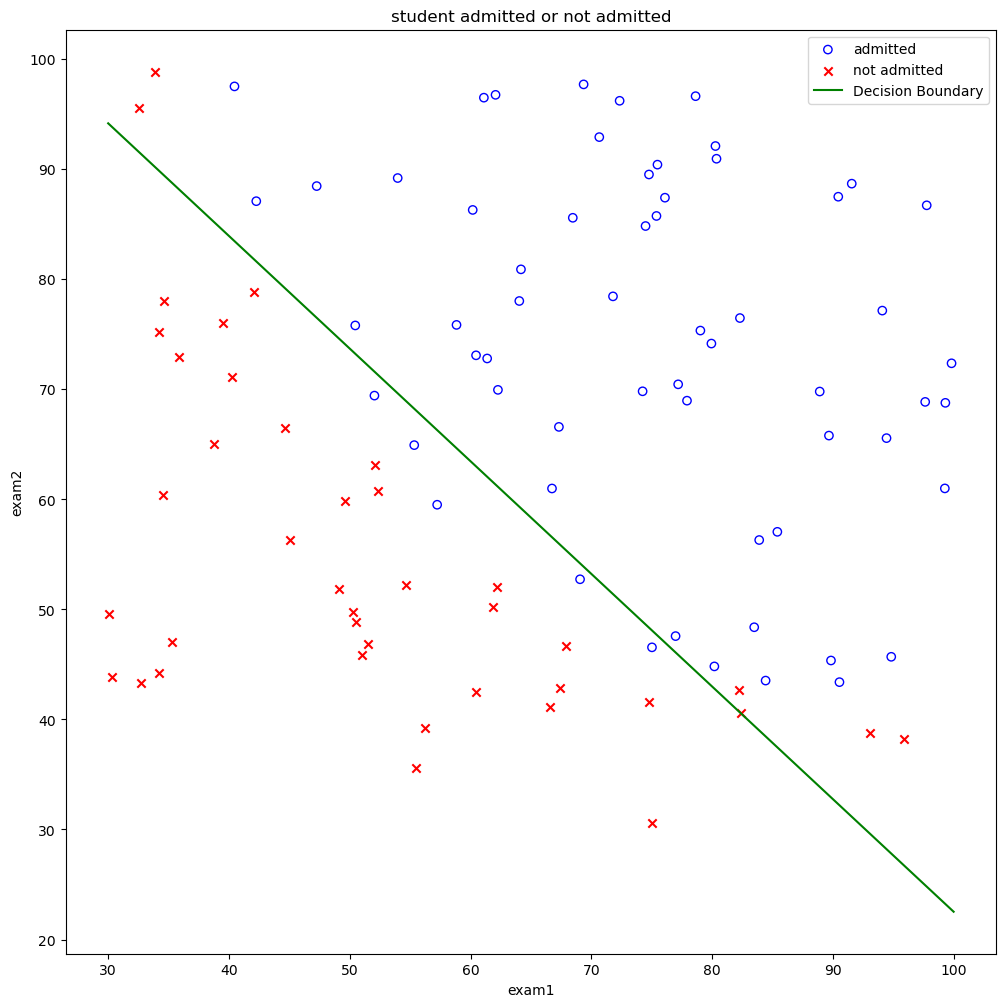

In [199]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.scatter(positive["exam1"],positive["exam2"],marker="o",edgecolors="blue",facecolors="none",label="admitted")
ax.scatter(negative["exam1"],negative["exam2"],marker="x",color="r",label="not admitted")
ax.plot(x1, x2, color="green", label="Decision Boundary")
ax.legend(loc="best")
ax.set_xlabel("exam1")
ax.set_ylabel("exam2")
ax.set_title("student admitted or not admitted")
plt.show()

接下来，我们需要编写一个函数，用我们所学的参数theta来为数据集X输出预测。然后，我们可以使用这个函数来给我们的分类器的训练精度打分。
逻辑回归模型的假设函数： 
	$${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$$
当${{h}_{\theta }}$大于等于0.5时，预测 y=1

当${{h}_{\theta }}$小于0.5时，预测 y=0 。

In [200]:
def predict(theta,X):
    probability = sigmoid(X@theta.T)
    predictions = []
    for x in probability:
        if x > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [201]:
theta = result[0]
predictions = predict(theta,X)

In [217]:
def judge(predictions,y):
    correct = []
    for (a,b) in zip(predictions,y):
        if (a == 1 and b == 1) or (a == 0 and b == 0):
            correct.append(1)
        else:
            correct.append(0)
    return correct

In [218]:
correct = judge(predictions,y)
accuracy = sum(correct) / len(correct)
print(f"accuracy = {accuracy*100}%")

accuracy = 89.0%


我们的逻辑回归分类器预测正确，如果一个学生被录取或没有录取，达到89%的精确度。不坏！记住，这是训练集的准确性。我们没有保持住了设置或使用交叉验证得到的真实逼近，所以这个数字有可能高于其真实值（这个话题将在以后说明）。